<a href="https://colab.research.google.com/github/ThalesF01/Projeto-Curso-IA/blob/main/ProjetoCursoIA/Projeto_curso_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Célula 1: Importar bibliotecas e warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import json
import warnings
import os
import joblib
import shap

warnings.filterwarnings("ignore")

In [2]:
# Célula 2: Carregar dataset
dataset = pd.read_csv("train.csv", keep_default_na=False)
y = dataset['income']
X = dataset.drop(columns=['income'])

In [3]:
# Célula 3: Colunas categóricas e tratamento de "?"
colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns
X[colunas_categoricas] = X[colunas_categoricas].replace("?", "Unknown")

def mostrar_categorias(df, colunas):
    for col in colunas:
        print(f"\nColuna: {col}")
        print(f"Número de categorias únicas: {df[col].nunique()}")
        print(df[col].value_counts(dropna=False))

mostrar_categorias(X, colunas_categoricas)


Coluna: workclass
Número de categorias únicas: 9
workclass
Private             23719
Self-emp-not-inc     2687
Local-gov            2194
Unknown              1969
State-gov            1389
Self-emp-inc         1197
Federal-gov          1009
Without-pay            17
Never-worked            8
Name: count, dtype: int64

Coluna: education
Número de categorias únicas: 16
education
HS-grad         11018
Some-college     7662
Bachelors        5622
Masters          1875
Assoc-voc        1441
11th             1271
Assoc-acdm       1104
10th              962
7th-8th           663
Prof-school       580
9th               509
12th              461
Doctorate         417
5th-6th           365
1st-4th           179
Preschool          60
Name: count, dtype: int64

Coluna: marital-status
Número de categorias únicas: 7
marital-status
Married-civ-spouse       15802
Never-married            11156
Divorced                  4625
Widowed                   1071
Separated                 1065
Married-spouse-a

In [4]:
# Célula 4: Agrupar categorias raras (<1% do total) como 'Others'
for col in colunas_categoricas:
    freq = X[col].value_counts(normalize=True)
    raras = freq[freq < 0.01].index
    X[col] = X[col].apply(lambda x: 'Others' if x in raras else x)

mostrar_categorias(X, colunas_categoricas)


Coluna: workclass
Número de categorias únicas: 8
workclass
Private             23719
Self-emp-not-inc     2687
Local-gov            2194
Unknown              1969
State-gov            1389
Self-emp-inc         1197
Federal-gov          1009
Others                 25
Name: count, dtype: int64

Coluna: education
Número de categorias únicas: 15
education
HS-grad         11018
Some-college     7662
Bachelors        5622
Masters          1875
Assoc-voc        1441
11th             1271
Assoc-acdm       1104
10th              962
7th-8th           663
Prof-school       580
9th               509
12th              461
Doctorate         417
5th-6th           365
Others            239
Name: count, dtype: int64

Coluna: marital-status
Número de categorias únicas: 7
marital-status
Married-civ-spouse       15802
Never-married            11156
Divorced                  4625
Widowed                   1071
Separated                 1065
Married-spouse-absent      445
Others                      25
Na

In [5]:
# Célula 5: Estatísticas das colunas numéricas
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
print(X[colunas_numericas].describe())

                age        fnlwgt  educational-num  capital-gain  \
count  34189.000000  3.418900e+04     34189.000000  34189.000000   
mean      38.689988  1.895613e+05        10.080903   1082.911229   
std       13.741874  1.055642e+05         2.572400   7505.749147   
min       17.000000  1.228500e+04         1.000000      0.000000   
25%       28.000000  1.176740e+05         9.000000      0.000000   
50%       37.000000  1.779370e+05        10.000000      0.000000   
75%       48.000000  2.377200e+05        12.000000      0.000000   
max       90.000000  1.484705e+06        16.000000  99999.000000   

       capital-loss  hours-per-week  
count  34189.000000    34189.000000  
mean      89.585832       40.436310  
std      407.092898       12.445302  
min        0.000000        1.000000  
25%        0.000000       40.000000  
50%        0.000000       40.000000  
75%        0.000000       45.000000  
max     4356.000000       99.000000  


In [6]:
# Célula 6: Padronização numérica
scaler = StandardScaler()
X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])

In [7]:
# Célula 7: Label Encoding
label_encoders = {}
for col in colunas_categoricas:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [8]:
# Célula 8: Aplicar SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
y_res = y_res.map({'<=50K':0, '>50K':1})
print("Distribuição após SMOTE:\n", y_res.value_counts())

Distribuição após SMOTE:
 income
0    25922
1    25922
Name: count, dtype: int64


In [9]:
# Célula 9: Função para GridSearch com JSON
def grid_search_model(model_name, estimator, param_grid, X, y, json_file):
    if os.path.exists(json_file):
        print(f"Carregando parâmetros salvos de {model_name}")
        with open(json_file, "r") as f:
            best_params = json.load(f)
        model = estimator.set_params(**best_params)
    else:
        print(f"Rodando GridSearch para {model_name}...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid = GridSearchCV(estimator, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
        grid.fit(X, y)
        best_params = grid.best_params_
        print(f"Melhores hiperparâmetros {model_name}: {best_params}")
        with open(json_file, "w") as f:
            json.dump(best_params, f)
        model = grid.best_estimator_
    return model

In [10]:
# Célula 10: Definir grids
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}
lgb_param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [11]:
# Célula 11: Treinar modelos (XGBoost + LightGBM)
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
best_xgb = grid_search_model("XGBoost", xgb_model, xgb_param_grid, X_res, y_res, "xgb_params.json")

lgb_model = lgb.LGBMClassifier(random_state=42)
best_lgb = grid_search_model("LightGBM", lgb_model, lgb_param_grid, X_res, y_res, "lgb_params.json")

Rodando GridSearch para XGBoost...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Melhores hiperparâmetros XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Rodando GridSearch para LightGBM...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Number of positive: 25922, number of negative: 25922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 51844, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores hiperparâmetros LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}


In [12]:
# Célula 12: Pré-processar conjunto de validação
df_val = pd.read_csv("validation.csv", keep_default_na=False)
X_val = df_val.drop(columns=['income'])
y_val = df_val['income'].map({'<=50K':0, '>50K':1})

# Categóricas
X_val[colunas_categoricas] = X_val[colunas_categoricas].replace("?", "Unknown")
for col, le in label_encoders.items():
    known = set(le.classes_)
    X_val[col] = X_val[col].apply(lambda x: x if x in known else 'Others')
    if 'Others' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Others')
    X_val[col] = le.transform(X_val[col])

# Numéricas
X_val[colunas_numericas] = scaler.transform(X_val[colunas_numericas])

In [13]:
# Célula 13: Threshold tuning para F1
def threshold_tuning(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:,1]
    prec, rec, thr = precision_recall_curve(y_val, probs)
    f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = f1s.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    print(f"Melhor threshold: {best_thr}, F1: {f1s[best_idx]}")
    y_pred = (probs >= best_thr).astype(int)
    print(classification_report(y_val, y_pred))
    return y_pred, best_thr

In [14]:
# Célula 14: Avaliar XGBoost e LightGBM
print("=== XGBoost ===")
y_pred_xgb, thr_xgb = threshold_tuning(best_xgb, X_val, y_val)

print("=== LightGBM ===")
y_pred_lgb, thr_lgb = threshold_tuning(best_lgb, X_val, y_val)

=== XGBoost ===
Melhor threshold: 0.5222922563552856, F1: 0.7180504392174099
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5642
           1       0.69      0.75      0.72      1684

    accuracy                           0.86      7326
   macro avg       0.81      0.82      0.81      7326
weighted avg       0.87      0.86      0.87      7326

=== LightGBM ===
Melhor threshold: 0.5080775841165837, F1: 0.7218795888394413
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5642
           1       0.71      0.73      0.72      1684

    accuracy                           0.87      7326
   macro avg       0.82      0.82      0.82      7326
weighted avg       0.87      0.87      0.87      7326



In [15]:
# Célula 15: Ensemble simples (soft voting)
probs_xgb = best_xgb.predict_proba(X_val)[:,1]
probs_lgb = best_lgb.predict_proba(X_val)[:,1]
probs_ens = (probs_xgb + probs_lgb)/2
y_pred_ens = (probs_ens >= 0.5).astype(int)
print("=== Ensemble XGB + LGB ===")
print(classification_report(y_val, y_pred_ens))
print("F1 Ensemble:", f1_score(y_val, y_pred_ens))

=== Ensemble XGB + LGB ===
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5642
           1       0.69      0.75      0.72      1684

    accuracy                           0.86      7326
   macro avg       0.81      0.82      0.81      7326
weighted avg       0.87      0.86      0.87      7326

F1 Ensemble: 0.716927453769559


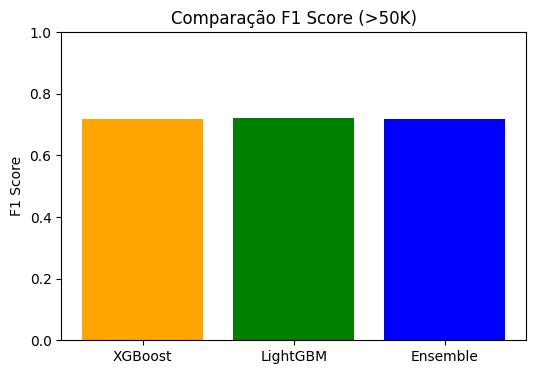

In [16]:
# Célula 16: Gráfico comparativo de F1
f1_scores = {
    "XGBoost": f1_score(y_val, y_pred_xgb),
    "LightGBM": f1_score(y_val, y_pred_lgb),
    "Ensemble": f1_score(y_val, y_pred_ens)
}

plt.figure(figsize=(6,4))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['orange','green','blue'])
plt.title("Comparação F1 Score (>50K)")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()

In [17]:
# Célula 17: Salvar modelos treinados
joblib.dump(best_xgb, "best_xgb.joblib")
joblib.dump(best_lgb, "best_lgb.joblib")

['best_lgb.joblib']

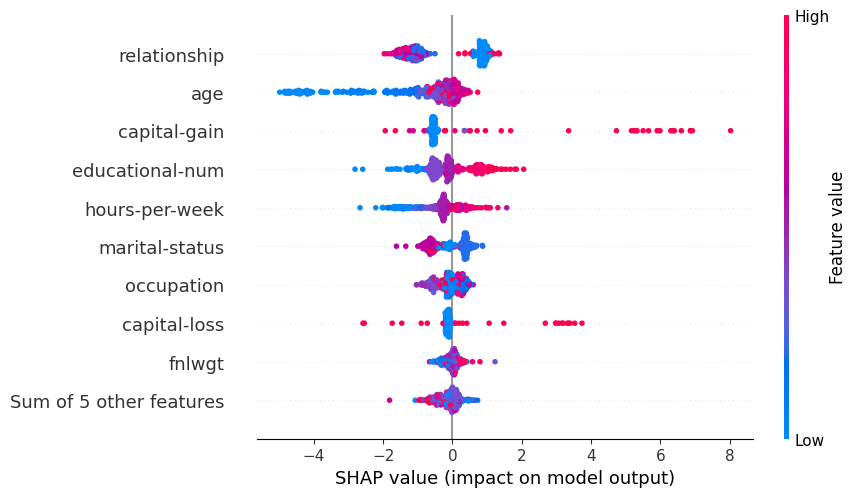

In [18]:
# Célula 18: SHAP (LightGBM exemplo)
explainer = shap.Explainer(best_lgb)
shap_values = explainer(X_val.sample(500, random_state=42))
shap.plots.beeswarm(shap_values)